# K-Means Clustering

# 1) Use the "Breast Cancer Wisconsin (Diagnostic) Data Set" from Kaggle to try and cluster types of cancer cells. 

Here's the original dataset for your reference:

<https://www.kaggle.com/uciml/breast-cancer-wisconsin-data>

## This is a supervised learning dataset

(Because it has **labels** - The "diagnosis" column.)

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this
from sklearn.preprocessing import StandardScaler # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Cancer_Cells.csv")
print(df.shape)
df.head()

(569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [0]:
# Saving the label of diagnosis so that I can use it later down 
# With checking my work
diagnosis_df = df['diagnosis']

## Now it's an unsupervised learning dataset

(Because we've removed the diagnosis label) - Use this version.

In [166]:
df = df.drop('diagnosis', axis=1)
df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## Let's do it!

- You might want to do some data exploration to see if you can find specific columns that will help you find distinct clusters of cells
- You might want to use the elbow method to decide on the number of clusters to use.


In [167]:
# Looking at the shape of the dataFrame
df.shape

(569, 32)

In [168]:
# Checking to see the if there are any null values in the dataframe
df.isnull().sum()

id                           0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32                569
dtype: i

In [169]:
# Checking the dtypes of the columns
df.dtypes

id                           int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

In [170]:
# Checking the unique values in the Unnamed : 32 column
df['Unnamed: 32'].value_counts(dropna=False)

NaN    569
Name: Unnamed: 32, dtype: int64

In [171]:
# I am dropping the Unnamed : 32 column because all it has is just NAN
df_cleaned = df.drop(columns='Unnamed: 32')
print(df_cleaned.shape)

(569, 31)


In [172]:
# Checking some of the columns value counts to see if the values may
# clustered 

# Will do a variance covariance matrix to see how much variance some of 
# columns have
df_cleaned.var(ddof=1)

id                         1.563015e+16
radius_mean                1.241892e+01
texture_mean               1.849891e+01
perimeter_mean             5.904405e+02
area_mean                  1.238436e+05
smoothness_mean            1.977997e-04
compactness_mean           2.789187e-03
concavity_mean             6.355248e-03
concave points_mean        1.505661e-03
symmetry_mean              7.515428e-04
fractal_dimension_mean     4.984872e-05
radius_se                  7.690235e-02
texture_se                 3.043159e-01
perimeter_se               4.087896e+00
area_se                    2.069432e+03
smoothness_se              9.015114e-06
compactness_se             3.207029e-04
concavity_se               9.111982e-04
concave points_se          3.807242e-05
symmetry_se                6.833290e-05
fractal_dimension_se       7.001692e-06
radius_worst               2.336022e+01
texture_worst              3.777648e+01
perimeter_worst            1.129131e+03
area_worst                 3.241674e+05


In [0]:
# Making a copy of the dataFrame to use for PCA and the clustering
df_clustering = df_cleaned.copy()
df_clustering_with_pca = df_cleaned.copy()

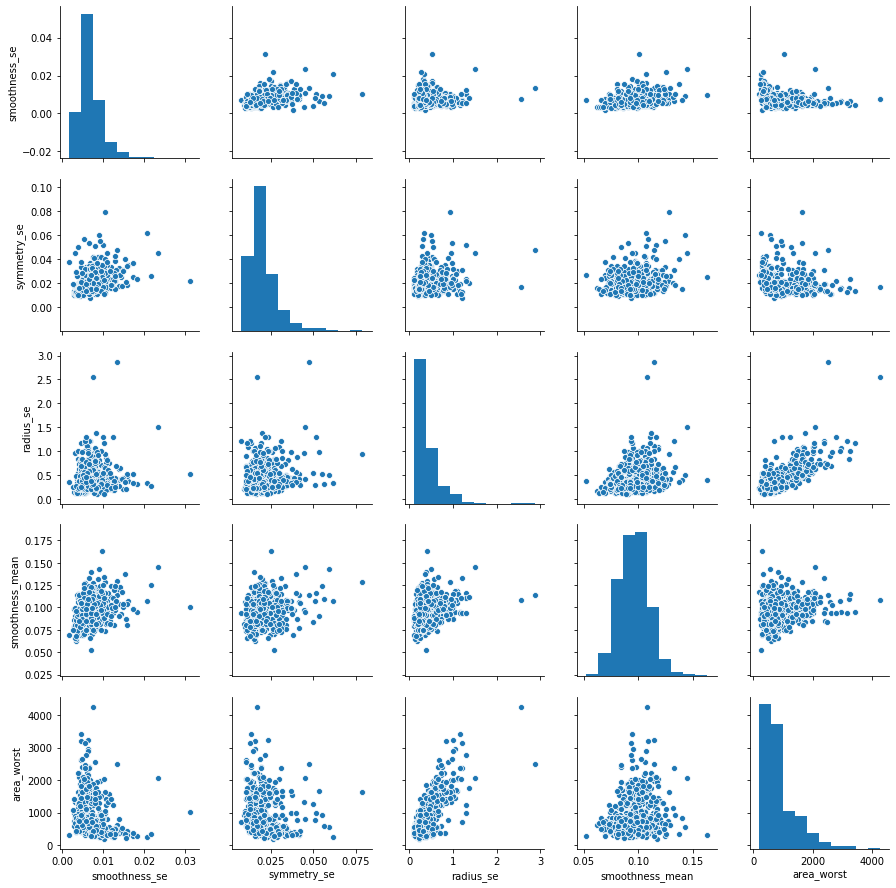

In [174]:
# Plotting some of the colums to see if they cluster
# Using pairplot from Seaborn to look at the data
# Chose a few of the columns to look at
import seaborn as sns
sns.pairplot(df_clustering, vars=['smoothness_se', 'symmetry_se', 'radius_se', 'smoothness_mean', "area_worst" ])


In [175]:
# Doing a kMeans cluster
theKmeans = KMeans(n_clusters=4)
theKmeans.fit(df_clustering)

# Getting the labels 
theLabels = theKmeans.labels_

df_clustering['Labels'] = pd.Series(theLabels)
print("The shape is " , df_clustering.shape)
df_clustering.head()


The shape is  (569, 32)


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Labels
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,2
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,2
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [0]:
# Finding who is in a cluster or clusters

def whosInTheCluster(df, whatClusters, clusterLabelName='Labels'):
  # Making a list that will hold all the clustered data we ask for
  theClusters =[]
  for clusterNum in whatClusters:
    theClusters.append(df[df[clusterLabelName]==clusterNum])
  return theClusters

In [177]:
# Getting cluster 1 2, and 3
tClusters = whosInTheCluster(df_clustering, [1, 2, 3])

for i in tClusters:
  print(i.head())
  print("\n")



            id  radius_mean  ...  fractal_dimension_worst  Labels
150  871001501       13.000  ...                  0.06435       1
151  871001502        8.219  ...                  0.14860       1
210  881046502       20.580  ...                  0.05865       1
213  881094802       17.420  ...                  0.06818       1
359  901034301        9.436  ...                  0.08136       1

[5 rows x 32 columns]


       id  radius_mean  ...  fractal_dimension_worst  Labels
0  842302        17.99  ...                  0.11890       2
1  842517        20.57  ...                  0.08902       2
5  843786        12.45  ...                  0.12440       2
6  844359        18.25  ...                  0.08368       2
8  844981        13.00  ...                  0.10720       2

[5 rows x 32 columns]


         id  radius_mean  ...  fractal_dimension_worst  Labels
19  8510426       13.540  ...                  0.07259       3
20  8510653       13.080  ...                  0.08183       3

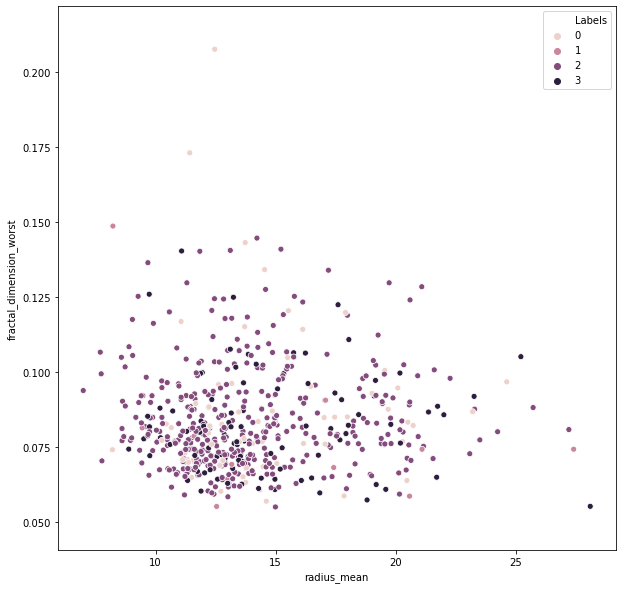

In [178]:
# Doing some plotting
fig, ax = plt.subplots(figsize=(10,10))

sns.scatterplot(x=df_clustering['radius_mean'], y=df_clustering['fractal_dimension_worst'],
                data=df_clustering, hue="Labels" )

## Check you work: 

This is something that in a truly unsupervised learning situation **WOULD NOT BE POSSIBLE**. But for educational purposes go back and grab the true diagnosis column (label) from the original dataset. Take your cluster labels and compare them to the original diagnosis column. You can make scatterplots for each to see how they compare or you can calculate a percent accuracy score like: 
\begin{align}
\frac{\text{Num Correct Labels}}{\text{Num Total Observations}}
\end{align}

In [179]:
# Grabbing back the label of malignancy to put 
#in with the data that has been clustered

df_clustering['diagnosis'] = diagnosis_df

df_clustering.head()


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Labels,diagnosis
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,2,M
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,2,M
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,M
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,M
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,M


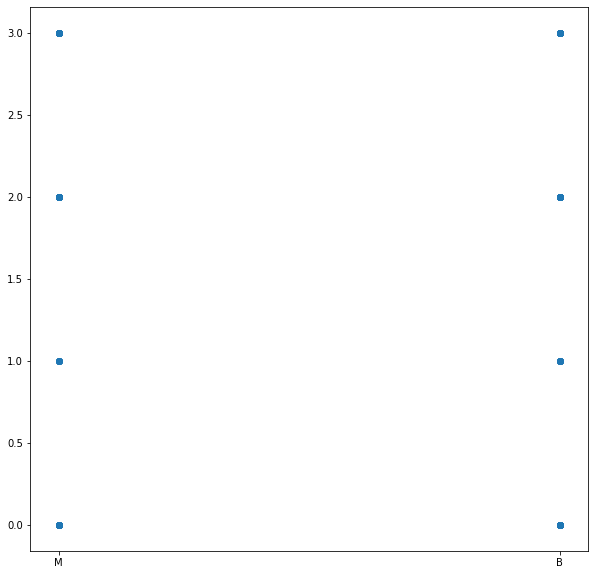

In [180]:
# Plotting
fig , ax = plt.subplots(figsize=(10,10))


plt.scatter(df_clustering['diagnosis'], df_clustering['Labels']);

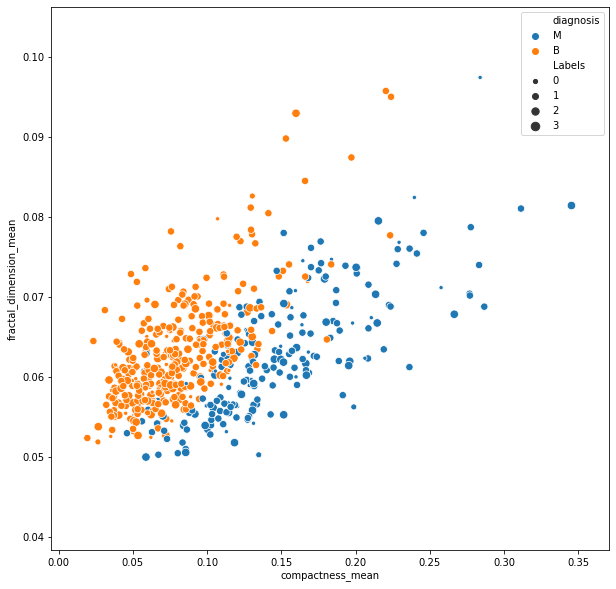

In [181]:
# Using Seaborn to plot
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(df_clustering['compactness_mean'], df_clustering['fractal_dimension_mean'], hue=df_clustering['diagnosis'], size=df_clustering['Labels'] )
# it didn't look like that it did too good with 3 clusters

In [182]:
# will do the same thing with two clusters only to see how well it groups
# them since there is only two groups it should be in Malignant or Benign
# I will copy the same code but just change the number of clusters


# Removing the diagnosis from the  dataframe
df_clustering = df_clustering.drop(['diagnosis', 'Labels'],  axis=1)
print(df_clustering.shape)
df_clustering.head(1)



(569, 31)


,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,0.2419,0.07871,1.095,0.9053,8.589,153.4,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189


In [183]:
# Doing a kMeans cluster
theKmeans = KMeans(n_clusters=2)
theKmeans.fit(df_clustering)

# Getting the labels 
theLabels = theKmeans.labels_

df_clustering['Labels'] = pd.Series(theLabels)
print("The shape is " , df_clustering.shape)


The shape is  (569, 32)


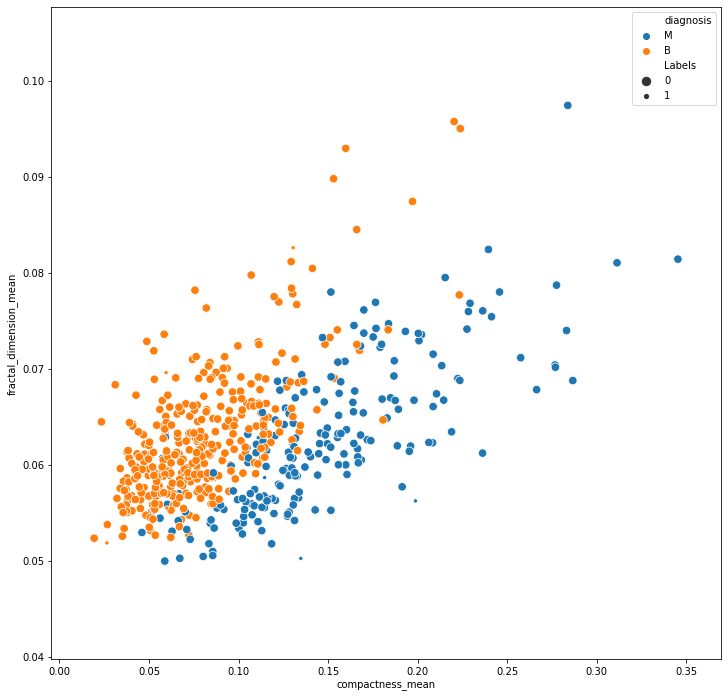

In [184]:
# Grabbing back the label of malignancy to put 
#in with the data that has been clustered

df_clustering['diagnosis'] = diagnosis_df

# Using Seaborn to plot
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(df_clustering['compactness_mean'], df_clustering['fractal_dimension_mean'],
                hue=df_clustering['diagnosis'], size=df_clustering['Labels'] )

In [185]:
# Finding the number of benigns
benign = df_clustering[df_clustering['diagnosis'] == 'B']
print("The number that are benign is: " , benign['diagnosis'].value_counts().sum())
benign['Labels'].value_counts()

The number that are benign is:  357


0    351
1      6
Name: Labels, dtype: int64

In [186]:
malignant = df_clustering[df_clustering['diagnosis'] == 'M']
print("The number that are malignant is: ", malignant['diagnosis'].value_counts().sum())
malignant['Labels'].value_counts()

The number that are malignant is:  212


0    207
1      5
Name: Labels, dtype: int64

In [187]:
# Finding the accuracy score
# The accuracy score is
accScore = (351 + 5)/(357 + 212)
print("The accuracy score is: ", accScore)

The accuracy score is:  0.6256590509666081


In [188]:
zero_group_benign['Labels'].value_counts()

0    351
1      6
Name: Labels, dtype: int64

# 2) Perform PCA on your dataset first and *then* use k-means clustering. 

- You need to standardize your data before PCA.
- First try clustering just on PC1 and PC2 so that you can make a scatterplot of your clustering.
- Then use use a scree plot to decide how many principal components to include in your clustering, and use however many principal components you need in order to retain 90% of the variation of the original dataset



In [0]:
# Getting the instance of the scaler
myScaler = StandardScaler()

In [0]:
# Getting the dataframe standardized
df_clustering_with_pca = myScaler.fit_transform(df_clustering_with_pca)

In [0]:
# Getting an instance of the PCA
pca = PCA(10)


In [0]:
# Applying the PCA to the data
pcaApplied = pca.fit_transform(df_clustering_with_pca)

In [194]:
# This shows that amount of variation in each of the components
pca.explained_variance_ratio_

array([0.42864701, 0.18376792, 0.09146436, 0.06391475, 0.05318759,
       0.03982815, 0.0315572 , 0.02166945, 0.01486427, 0.01300429])

In [196]:
# This is the shape of the nparray with the 10 components
pcaApplied.shape

(569, 10)

In [197]:
# Putting it in a dataframe
colNames=['comp_1', 'comp_2', 'comp_3', 'comp_4', 
          'comp_5', 'comp_6', 'comp_7', 'comp_8', 'comp_9', 'comp_10']

completeCompPCA = pd.DataFrame(pcaApplied, columns=colNames)
completeCompPCA.head(2)

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10
0,9.183200,1.971271,-1.171625,3.639332,-1.193098,-1.372280,0.371844,2.180529,-0.231614,-0.090393
1,2.383298,-3.753459,-0.580229,1.127438,0.624850,-0.126616,-0.288270,0.044935,0.426918,-0.659942


In [208]:
# Taking out the first two component to do the clustering on
comp1_and2 = completeCompPCA[['comp_1', 'comp_2']]
comp1_and2.head(2)

,comp_1,comp_2
0,9.183200,1.971271
1,2.383298,-3.753459


In [0]:
# Doing the clustering on the two components
tKmeans = KMeans(2)

tKmeans.fit(comp1_and2)

mLabels = tKmeans.labels_

In [210]:
comp1_and2['Labels'] = pd.Series(mLabels)
comp1_and2.head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,comp_1,comp_2,Labels
0,9.183200,1.971271,1
1,2.383298,-3.753459,1


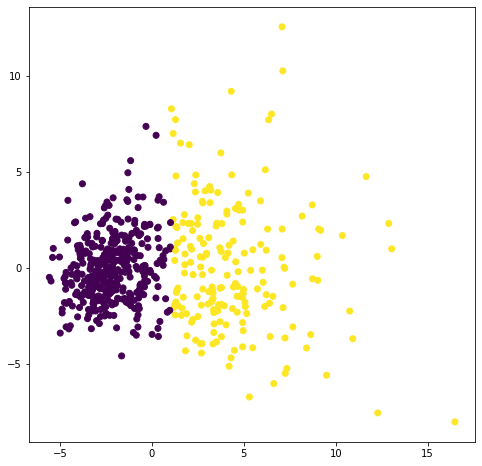

In [212]:
# This is the plot of the 2 components also then clustered in to two groups
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(comp1_and2['comp_1'], comp1_and2['comp_2'], c=comp1_and2['Labels'])

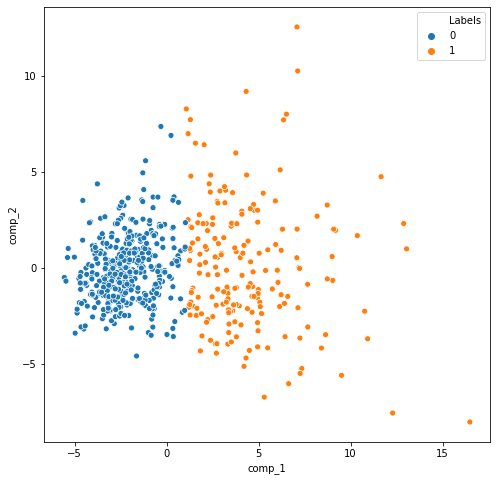

In [215]:
# This is plotting in seaborn
fig, ax =plt.subplots(figsize=(8,8))
sns.scatterplot(comp1_and2['comp_1'], comp1_and2['comp_2'], hue=comp1_and2['Labels'])


## Check your work: 

- Compare your PC1, PC2 clustering scatterplot to the clustering scatterplots you made on the raw data
- Calculate accuracy scores for both the PC1,PC2 Principal component clustering and the 90% of explained variance clustering.

How do your accuracy scores -when preprocessing the data with PCA- compare to the accuracy when simply clustering on the raw data?

# Stretch Goals:

- Study for the Sprint Challenge
- Work on your Data Storytelling Project